In [88]:
from netCDF4 import Dataset
#ds=xr.Dataset({'zMeas':zMeasX,'bcf':bcfX,'bsfc':bsfcX,'bzd':bzdX,'pFlag':pFlagX,'bbFlag':bbFlagX,'dm':dmX,'pRate':pRateX,'zeroDegAlt':zeroDegAltX})
#compres={'zlib':True,'complevel':5}
#encoding={'zMeas':compres,'bcf':compres,'bsfc':compres,'bzd':compres,'pFlag':compres,'bbFlag':compres,'dm':compres,'pRate':compres,'zeroDegAlt':compres}

#ds.to_netcdf('dpr_cmb.nc',encoding=encoding)

with Dataset('dpr_cmb_all.nc') as f:
    zMeas=f['zMeas'][:]
    bcf=f['bcf'][:]
    bsfc=f['bsfc'][:]
    bzd=f['bzd'][:]
    pFlag=f['pFlag'][:]
    bbFlag=f['bbFlag'][:]
    dm=f['dm'][:]
    pRate=f['pRate'][:]
    pType=f['pType'][:]
    nearSfcPrecip=f['nearSfcPrecip'][:]
    PIAhybrid=f['PIAhybrid'][:]


In [89]:
import numpy as np
nt=zMeas.shape[0]
for i in range(nt):
    for j in range(4):
        zMeas[i,j,bcf[i,j]:,0]=0
        zMeas[i,j,bcf[i,j]:,1]=0


In [90]:
zMeas[zMeas<0]=0
zMeas2=np.log10(0.5*10**(0.1*zMeas[:,:,::2,:])+0.5*10**(0.1*zMeas[:,:,1::2,:]))*10

In [91]:
zMeas2[zMeas2<0]=0
zMean=np.mean(zMeas2,axis=(0,1))
zStd=np.std(zMeas2,axis=(0,1))


In [92]:
PIAhybrid[PIAhybrid<0]=0

In [6]:
from sklearn.model_selection import train_test_split


In [7]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class projNet(nn.Module):
    def __init__(self, nin, nout, nh):
        super(projNet, self).__init__()
        self.nin=nin
        self.nout=nout
        self.nh=nh
        self.fc1 = nn.Linear(nin, nh)
        self.fc2 = nn.Linear(nh, nh)
        self.fc3 = nn.Linear(nh, nout)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
# define lstm model in pytorch
# input consists of nbin x 2 variables
# output consists of nbin x 2 variables
# hidden state consists of nbin x 16 variables
# hidden state is updated at each time step
class bayesian_lstm(nn.Module):
    def __init__(self, nin, nout, nh1, nh):
        super(bayesian_lstm, self).__init__()
        self.nin=nin
        self.nout=nout
        self.nh=nh
        self.nh1=nh1
        self.lstm = nn.LSTM(nin, 2*nh1,  batch_first=True)
        self.lstm2= nn.LSTM(nh1, nh, batch_first=True)
        self.fc = nn.Linear(nh, nout)
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h01 = torch.zeros(1, x.size(0), 2*self.nh1).to('cpu')
        c01 = torch.zeros(1, x.size(0), 2*self.nh1).to('cpu')

        h02 = torch.zeros(1, x.size(0), self.nh).to('cpu')
        c02 = torch.zeros(1, x.size(0), self.nh).to('cpu')
        #print(x.shape)
        #print(h0.shape)
        out, _ = self.lstm(x, (h01, c01))
        mu1, logvar1 = torch.split(out, out.size(2) // 2, dim=2)
        z1 = self.reparametrize(mu1, logvar1)
        out, _ = self.lstm2(z1, (h02, c02))
        out = self.fc(out)
        return out, mu1, logvar1
    


In [10]:
# import functional F
import torch.nn.functional as F

def kl_divergence(mu1, logvar1, mu2, logvar2):
  # KL divergence between two normal distributions
  # mu1, logvar1: first distribution parameters
  # mu2, logvar2: second distribution parameters
  epsilon = 1e-10
  return 0.5 * (logvar2 - logvar1 - 1 + torch.exp(logvar1 - logvar2) + ((mu1 - mu2) ** 2) / torch.exp(logvar2) + epsilon)

class BayesLSTMLoss(nn.Module):
  def __init__(self, lambda_ = 1.0):
    super(BayesLSTMLoss, self).__init__()
    self.lambda_ = lambda_  
  def forward(self, pred_y, pred_mu, pred_logvar, target):
    # Reconstruction loss (e.g., MSE)
    recon_loss = F.mse_loss(pred_y, target)
    #print(recon_loss.shape)
    # KL divergence loss
    kl_loss = kl_divergence(pred_mu, pred_logvar, torch.zeros_like(pred_mu), torch.zeros_like(pred_logvar))
    # Combine losses (weighted sum)
    #print(kl_loss.shape)
    return recon_loss + kl_loss.mean() * self.lambda_  # Adjust weight factor (lambda) as needed
  
criterion=BayesLSTMLoss()


In [86]:
#print(lstm_model.parameters)
#total_params = sum(p.numel() for p in bayesian_lstm_model.parameters())
#print(f'{total_params:,} total parameters.')

5,442 total parameters.


In [93]:
print(pType[0,:])

[0 0 1 1]


In [95]:
dn=3
a=np.nonzero(nearSfcPrecip[:,dn]>0.1)
print(len(a[0]))

xL=[]
yL=[]
x1L=[]

for i in a[0]:
    n1=int(bcf[i,dn]/2)
    nbzd=int(bzd[i,dn]/2)
    z1=zMeas2[i,dn,n1-64:n1,0]
    z2=zMeas2[i,dn,n1-64:n1,1]
    pRate1=pRate[i,dn,n1-64:n1]
    dm1=dm[i,dn,n1-64:n1]
    h1=np.arange(n1-64,n1)
    h1-=nbzd
    xL.append([z1,z2,h1,dm1])   
    yL.append([pRate1])

    xbb=bbFlag[i,dn]
    xbzd=(bzd[i,dn]-144)/5.
    xsfc=(bsfc[i,dn,0]-173)/5.
    xpia=(PIAhybrid[i,dn,0]-0.3)/0.7
    xbcf=(176-bcf[i,dn])/10.
    xprflag=(pFlag[i,dn]-5)/5
    xtype=pType[i,dn]
    x1L.append([xbb,xbzd,xsfc,xpia,xbcf,xprflag,xtype/3.0])
    #break

xL=np.array(xL)
yL=np.array(yL)


339696


In [96]:
x1L=np.array(x1L)
print(x1L.shape)

(339696, 7)


In [97]:
xm=xL.mean(axis=0)
xs=xL.std(axis=0)
ym=yL.mean(axis=0)
ys=yL.std(axis=0)
xLs=(xL.copy()).swapaxes(1,2)
yLs=(yL.copy()).swapaxes(1,2)
for i in range(1):
    xLs[:,:,i]=(xLs[:,:,i])/20.
for i in range(1,3):
    xLs[:,:,i]=(xLs[:,:,i])/10.

xLs[:,:,3]=(xLs[:,:,3])/4

print(yLs.shape)
yLs[:,:,0]=yLs[:,:,0]/10


(339696, 64, 1)


In [98]:
# Define custom dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
print(xL.shape)
#swap axes to get the right shape
x_train, x_test, y_train, y_test, x1_train, x1_test = train_test_split(xLs, yLs, x1L, test_size=0.1, random_state=42)
class CustomDataset(Dataset):
    def __init__(self, x_train, x1_train, y_train, transform=None):
        self.x_train = torch.tensor(x_train, dtype=torch.float32, device='cpu')
        self.y_train = torch.tensor(y_train, dtype=torch.float32, device='cpu')
        self.x1_train = torch.tensor(x1_train, dtype=torch.float32, device='cpu')
        self.transform = transform

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        sample = self.x_train[idx], self.x1_train[idx],self.y_train[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
dataSet=CustomDataset(x_train, x1_train, y_train)
batch_size = 64
shuffle = True
train_loader = DataLoader(dataSet, batch_size=batch_size, shuffle=shuffle)

(339696, 4, 64)


In [99]:
print(x_train.shape)
print(y_train.shape)

(305726, 64, 4)
(305726, 64, 1)


In [101]:
#define optimizer and loss function
import torch.optim as optim
import torch.nn as nn

criterion = BayesLSTMLoss(lambda_=5)
#lstm_model=lstm(3,1,16)
lstm_model=bayesian_lstm(5,1,16,32)
projOperator=projNet(7,2*64,32)
parameters=list(lstm_model.parameters())+list(projOperator.parameters())
optimizer = optim.Adam(parameters, lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, x1_input, outputs = data
        #print(inputs.shape)
        #print(outputs.shape)
        #break
        optimizer.zero_grad()
        yout_1=projOperator(x1_input.view(-1,7))
        yout_2=yout_1.view(-1,64,2)
        x_inputs=torch.cat((inputs[:,:,0:3],yout_2),dim=2)
        outputs_p, pred_mu, pred_log = lstm_model(x_inputs[:,:,0:5])
        loss = criterion(outputs_p, pred_mu, pred_log, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 600 == 599:    # print every 600 mini-batches
            #print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {running_loss/i:.4f}')
            print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {running_loss/150:.4f}')
            running_loss = 0.0

Epoch 1, Iteration 600, Loss: 0.4781
Epoch 1, Iteration 1200, Loss: 0.3093
Epoch 1, Iteration 1800, Loss: 0.2471
Epoch 1, Iteration 2400, Loss: 0.2498
Epoch 1, Iteration 3000, Loss: 0.2553
Epoch 1, Iteration 3600, Loss: 0.2450
Epoch 1, Iteration 4200, Loss: 0.2215
Epoch 2, Iteration 600, Loss: 0.2174
Epoch 2, Iteration 1200, Loss: 0.2269
Epoch 2, Iteration 1800, Loss: 0.2171
Epoch 2, Iteration 2400, Loss: 0.2177
Epoch 2, Iteration 3000, Loss: 0.2030
Epoch 2, Iteration 3600, Loss: 0.2229
Epoch 2, Iteration 4200, Loss: 0.1955


In [33]:
yout=lstm_model(x_inputs[:,:,:])

In [83]:

yout_1=projOperator(torch.tensor(x1_test, dtype=torch.float32, device='cpu').view(-1,7))
yout_2=yout_1.view(-1,64,2)
x_inputs=torch.cat((torch.tensor(x_test[:,:,0:3],dtype=torch.float32),yout_2),dim=2)


In [84]:
y_pL=[]
for i in range(4):
    y_p,mu,logvar=lstm_model(x_inputs)#torch.tensor(x_test[:,:,:3], dtype=torch.float32, device='cpu'))
    y_pL.append(y_p.detach().numpy())
#print(y.shape)
print(np.mean(y_p.detach().numpy()),np.mean(y_test))

0.22046176 0.21248037


(95,)
(40, 6811, 64, 1)


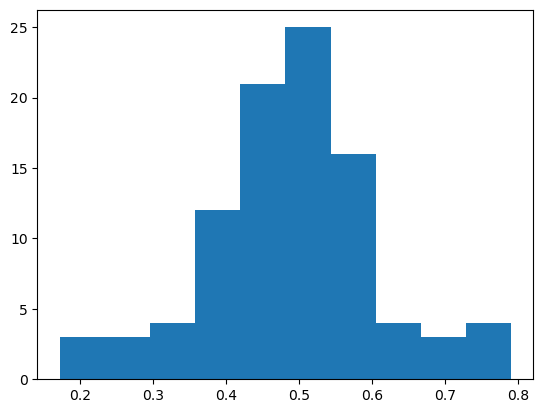

In [85]:
import matplotlib.pyplot as plt
y_pL=np.array(y_pL)
a=np.nonzero(y_pL[0,:,-1,0]>3)
ystd=y_pL[:,a[0],-1,0].std(axis=(0))
print(ystd.shape)
print(y_pL.shape)
h1=plt.hist(ystd)

In [86]:

total_params1 = sum(p.numel() for p in lstm_model.parameters())
print(f'{total_params1:,} total parameters.')
total_params2 = sum(p.numel() for p in projOperator.parameters())
print(f'{total_params2:,} total parameters.')
print(x1L.shape)

11,425 total parameters.
5,504 total parameters.
(68108, 6)


[[1.         0.72379267]
 [0.72379267 1.        ]]
[[1.         0.85163715]
 [0.85163715 1.        ]]


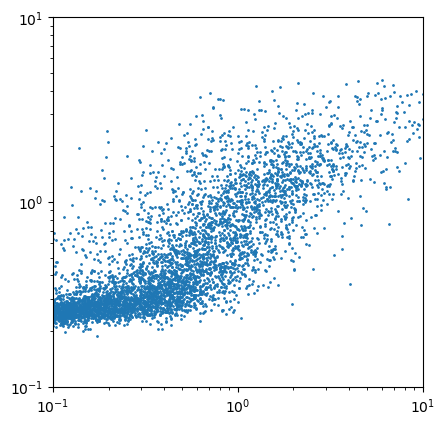

In [87]:
y_p=y_pL[0]
y_p=np.array(y_pL).mean(axis=0)
print(np.corrcoef(y_test[:,-1,0],y_p[:,-1,0]))
print(np.corrcoef(y_pL[1][:,-1,0],y_pL[0][:,-1,0]))
#print(np.corrcoef(y_test[:,-1,1],y_p[:,-1,1]))
ax=plt.subplot(111)
plt.scatter(y_test[:,-1,0],y_p[:,-1,0],s=1)
plt.xlim(0.1,10)
plt.ylim(0.1,10)
plt.xscale('log')
plt.yscale('log')
ax.set_aspect('equal')